In [1]:
#from textblob import TextBlob
import pandas as pd
import re, string
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install top2vec
!pip install top2vec[sentence_transformers]
!pip install top2vec[sentence_encoders]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# !pip install pyLDAvis

In [4]:
# # libraries for visualization
# import pyLDAvis
# import pyLDAvis.gensim
# import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
review_data = pd.read_csv('/content/drive/MyDrive/Amazon reviews/sample_data_for_topic_modelling.csv')

#**Data pre-processing**

In [7]:
review_data

,Unnamed: 0.1,Unnamed: 0,ID,Subject,Description,sub_words_count,sub_char_count,desc_words_count,desc_char_count,Cleaned_Desc,...,desc_score,desc_sentiment,Date/Time Opened,Case Category,Category,Sub Category,Case Close Reason,Product Type,Origin,Top Management Flag
0,30,30,31,Planet App Feedback,Very poor customer service no response from yo...,3,19,21,143,Very poor customer service no response from yo...,...,0.9392,negative,2022-12-31T19:12:39.000+0000,Feedback,PLANET feedback,Negative Feedback,NaN,Two Wheeler,Mobile app,No
1,131,131,132,L&T Financial Services - General Enquiry,Two wheeler loan still not update\n\n-- \nDisc...,6,40,176,1115,Two wheeler loan still not update,...,0.6240,negative,2022-12-31T19:49:36.000+0000,Query,Payment & Refund,Payment Confirmation,Refer to this case id :17768143,Two Wheeler,Email,No
2,167,167,168,Loan not clear,NAME - NARMADA DAS\nMOBILE NO - 9678183958\nLO...,3,14,205,1265,NAME NARMADA DAS MOBILE NO LOAN NO C I have pa...,...,0.6760,negative,2022-12-31T20:07:44.000+0000,Query,Account Closure,Account Status is Active,"Dear Customer,\r\n\r\nThank you for writing to...",Consumer Loan,Email,No
3,226,226,227,L&T Financial Services - General Enquiry,"Dear Team,\n\n\nI have already paid the emi of...",6,40,214,1355,Dear Team I have already paid the emi of rd Ja...,...,0.4921,negative,2022-12-31T20:51:17.000+0000,Query,General Enquiry,LTFS Related,We acknowledge the receipt of your email and a...,Others,Email,No
4,292,292,293,LAN C022122501011708,"Dear Sir/Madam,\n\nI have taken loan from you ...",2,20,258,1571,Dear Sir Madam I have taken loan from you but ...,...,0.7081,negative,2022-12-31T21:58:37.000+0000,Query,Insurance,Insurance Related,We regret to inform you that we are unable to ...,Consumer Loan,Email,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25124,713736,713736,713737,L&T Financial Services - General Enquiry,sending email my DOB is wrong plz give me opti...,6,40,182,1142,sending email my DOB is wrong plz give me opti...,...,0.6904,negative,2023-01-30T17:39:02.000+0000,Query,Unsuccessful Interaction,Authentication Failed,The security of your account is of paramount i...,Two Wheeler,Email,No
25125,713753,713753,713754,Planet App Feedback,"Services, Unable to update Mobile no./Address",3,19,6,45,Services Unable to update Mobile no Address,...,0.7875,negative,2023-01-30T17:46:14.000+0000,Feedback,PLANET feedback,Negative Feedback,NaN,NaN,Mobile app,No
25126,713779,713779,713780,Planet App Feedback,I'm a zero experience,3,19,4,21,I'm a zero experience,...,0.7380,negative,2023-01-30T17:53:11.000+0000,Feedback,PLANET feedback,Negative Feedback,NaN,Two Wheeler,Mobile app,No
25127,713786,713786,713787,L&T Financial Services - General Enquiry,sending email my name is jaskaran Singh my loa...,6,40,344,1988,sending email my name is jaskaran Singh my loa...,...,0.7044,negative,2023-01-30T17:55:11.000+0000,Query,Repo and Yard management,Post Repo concern,We would like to inform you that please visit ...,Two Wheeler,Email,No


In [8]:
#print('Number of unique reviews:', review_data['Text'].nunique())
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25129 entries, 0 to 25128
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0.1              25129 non-null  int64  
 1   Unnamed: 0                25129 non-null  int64  
 2   ID                        25129 non-null  int64  
 3   Subject                   24794 non-null  object 
 4   Description               25129 non-null  object 
 5   sub_words_count           25129 non-null  int64  
 6   sub_char_count            25129 non-null  int64  
 7   desc_words_count          25129 non-null  int64  
 8   desc_char_count           25129 non-null  int64  
 9   Cleaned_Desc              25129 non-null  object 
 10  cleaned_desc_words_count  25129 non-null  int64  
 11  subject_score             25129 non-null  float64
 12  subject_sentiment         25129 non-null  object 
 13  desc_score                25129 non-null  float64
 14  desc_s

In [9]:
mask = (review_data['desc_score']>=0.8)
review_data = review_data[mask]

In [10]:
review_data.shape

(4388, 23)

In [11]:
#this function will remove special characters, digits and words having characters less than or equal to three
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join(textArr) 
    
    return text2.lower()

In [12]:
# review_data.dropna(axis = 0, how ='any',inplace=True) 
review_data['Cleaned_Desc'] = review_data['Cleaned_Desc'].apply(clean_text)
# review_data['Num_words_text'] = review_data['Text'].apply(lambda x:len(str(x).split())) 

# print('-------Dataset --------')
# print(review_data['Score'].value_counts())
# print('-------------------------')
# # max_review_data_sentence_length  = review_data['Num_words_text'].max()

# mask = (review_data['Num_words_text'] < 30) & (review_data['Num_words_text'] >=5)
# df_short_reviews = review_data[mask]

# #sample only 5000 instances for each value of score, in total 5*5000 instances
# df_sampled = df_short_reviews.groupby('Score').apply(lambda x: x.sample(n=5000)).reset_index(drop = True)

# print('No of Short reviews')
# print(len(df_short_reviews))

In [13]:
review_data

,Unnamed: 0.1,Unnamed: 0,ID,Subject,Description,sub_words_count,sub_char_count,desc_words_count,desc_char_count,Cleaned_Desc,...,desc_score,desc_sentiment,Date/Time Opened,Case Category,Category,Sub Category,Case Close Reason,Product Type,Origin,Top Management Flag
0,30,30,31,Planet App Feedback,Very poor customer service no response from yo...,3,19,21,143,very poor customer service no response from yo...,...,0.9392,negative,2022-12-31T19:12:39.000+0000,Feedback,PLANET feedback,Negative Feedback,NaN,Two Wheeler,Mobile app,No
9,533,533,534,Planet App Feedback,"Services, Unsuccessful Mandate registration",3,19,4,43,services unsuccessful mandate registration,...,0.8449,negative,2023-01-01T02:55:14.000+0000,Feedback,PLANET feedback,Negative Feedback,NaN,MFI,Mobile app,No
11,576,576,577,Planet App Feedback,"Services, Unsuccessful Mandate registration, N...",3,19,5,53,services unsuccessful mandate registration non...,...,0.8663,negative,2023-01-01T03:20:58.000+0000,Feedback,PLANET feedback,Negative Feedback,NaN,Two Wheeler,Mobile app,No
12,590,590,591,Planet App Feedback,"Technical, Slowness in Application, No option ...",3,19,13,88,technical slowness in application no option is...,...,0.8383,negative,2023-01-01T03:34:53.000+0000,Feedback,PLANET feedback,Negative Feedback,NaN,NaN,Mobile app,No
20,738,738,739,Planet App Feedback,"Services, Unsuccessful Mandate registration, b...",3,19,11,83,services unsuccessful mandate registration bad...,...,0.9320,negative,2023-01-01T04:05:21.000+0000,Feedback,PLANET feedback,Negative Feedback,NaN,NaN,Mobile app,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25115,713496,713496,713497,Planet App Feedback,"Technical, App slow",3,19,3,19,technical app slow,...,0.8155,negative,2023-01-30T15:57:07.000+0000,Feedback,PLANET feedback,Negative Feedback,NaN,Two Wheeler,Mobile app,No
25116,713514,713514,713515,Planet App Feedback,"Services, I already closed my loan,but till it...",3,19,27,153,services i already closed my loan but till it ...,...,0.9282,negative,2023-01-30T16:03:07.000+0000,Feedback,PLANET feedback,Negative Feedback,NaN,Two Wheeler,Mobile app,No
25117,713570,713570,713571,Planet App Feedback,"Services, Unsuccessful Mandate registration",3,19,4,43,services unsuccessful mandate registration,...,0.8449,negative,2023-01-30T16:26:31.000+0000,Feedback,PLANET feedback,Negative Feedback,NaN,Two Wheeler,Mobile app,No
25121,713650,713650,713651,Request--Payment & Refund--Receipt Cancellatio...,dear team \r\n\r\nplease cancel the receipt S2...,5,66,7,52,dear team please cancel the receipt s,...,0.8457,negative,2023-01-30T16:59:39.000+0000,Request,Payment & Refund,Receipt Cancellation,"Dear Team,\nReceipt cancellation has been done...",Farm,Branch - Walk-in,No


$\Large\text{As can be seen from the above result that special charcters, stopwords, digits are removed from the text.}$

In [14]:
!pip uninstall numba

Found existing installation: numba 0.57.0
Uninstalling numba-0.57.0:
  Would remove:
    /usr/local/bin/numba
    /usr/local/lib/python3.10/dist-packages/numba-0.57.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numba/*
Proceed (Y/n)? Y
  Successfully uninstalled numba-0.57.0


In [15]:
!pip install numba --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numba-0.57.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.6 MB)


In [16]:
from top2vec import Top2Vec

In [39]:
model = Top2Vec(review_data.Cleaned_Desc.values, embedding_model='universal-sentence-encoder')

2023-05-23 08:52:34,497 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2023-05-23 08:52:35,061 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2023-05-23 08:52:43,474 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-05-23 08:52:45,519 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-05-23 08:53:08,285 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-05-23 08:53:08,535 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [40]:
model.get_num_topics()

36

In [19]:
topic_sizes, topic_nums = model.get_topic_sizes()

In [20]:
print(topic_sizes)

[831 573 558 349 324 230 120 106  97  86  77  75  74  69  63  60  59  51
  49  47  39  39  39  36  35  34  34  33  33  31  27  25  25  24  19  17]


In [41]:
topic_words, word_scores, topic_nums = model.get_topics(36)

In [42]:
for i in range(36):
  print('Length of topic', i, ':', len(topic_words[i]))

Length of topic 0 : 50
Length of topic 1 : 50
Length of topic 2 : 50
Length of topic 3 : 50
Length of topic 4 : 50
Length of topic 5 : 50
Length of topic 6 : 50
Length of topic 7 : 50
Length of topic 8 : 50
Length of topic 9 : 50
Length of topic 10 : 50
Length of topic 11 : 50
Length of topic 12 : 50
Length of topic 13 : 50
Length of topic 14 : 50
Length of topic 15 : 50
Length of topic 16 : 50
Length of topic 17 : 50
Length of topic 18 : 50
Length of topic 19 : 50
Length of topic 20 : 50
Length of topic 21 : 50
Length of topic 22 : 50
Length of topic 23 : 50
Length of topic 24 : 50
Length of topic 25 : 50
Length of topic 26 : 50
Length of topic 27 : 50
Length of topic 28 : 50
Length of topic 29 : 50
Length of topic 30 : 50
Length of topic 31 : 50
Length of topic 32 : 50
Length of topic 33 : 50
Length of topic 34 : 50
Length of topic 35 : 50


In [23]:
print(word_scores)

[[0.38817137 0.29881954 0.2883386  ... 0.07875414 0.07671234 0.07462171]
 [0.5094968  0.4689095  0.38239276 ... 0.11269044 0.11227472 0.11226498]
 [0.3668004  0.32106534 0.31430495 ... 0.14303875 0.14231935 0.14216426]
 ...
 [0.365658   0.33997366 0.27966034 ... 0.03961071 0.03796814 0.03752568]
 [0.5272707  0.31055158 0.26357216 ... 0.04075917 0.03946817 0.03931   ]
 [0.35170954 0.26298815 0.2587282  ... 0.04766534 0.04392848 0.04372044]]


In [24]:
print(topic_words)

[['call' 'calls' 'response' ... 'server' 'warning' 'any']
 ['technical' 'slowness' 'slow' ... 'account' 'failed' 'agentlanguage']
 ['loan' 'emi' 'payments' ... 'charges' 'cancel' 'indian']
 ...
 ['customer' 'disconnected' 'customers' ... 'no' 'problem' 'cx']
 ['cx' 'dropped' 'callcall' ... 'jan' 'end' 'support']
 ['disconnected' 'calls' 'call' ... 'inform' 'clear' 'support']]


In [25]:
for i in range(36):
  print("\033[1m"+'Topic', i, "\033[0m", topic_words[i])

Topic 0  ['call' 'calls' 'response' 'drop' 'calling' 'dropped' 'end' 'disconnected'
 'customer' 'cancel' 'request' 'told' 'closure' 'called' 'customers'
 'unsuccessful' 'issue' 'stop' 'loss' 'disconnect' 'slow' 'failed' 'send'
 'worst' 'pay' 'email' 'sender' 'final' 'file' 'emi' 'last' 'application'
 'update' 'support' 'no' 'back' 'sending' 'letter' 'foreclosure' 'account'
 'service' 'number' 'mail' 'kotak' 'get' 'callcall' 'said' 'server'
 'warning' 'any']
Topic 1  ['technical' 'slowness' 'slow' 'application' 'unable' 'process' 'app'
 'service' 'request' 'calling' 'server' 'calls' 'customer' 'call'
 'subject' 'cannot' 'attachments' 'issue' 'time' 'loan' 'email' 'paying'
 'site' 'contact' 'voice' 'details' 'transferred' 'services' 'payment'
 'rtgs' 'file' 'clear' 'policy' 'use' 'problem' 'past' 'working' 'cant'
 'disconnected' 'person' 'date' 'update' 'barrier' 'called' 'branch'
 'payments' 'registration' 'account' 'failed' 'agentlanguage']
Topic 2  ['loan' 'emi' 'payments' 'payment' '

In [26]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["registration"], num_topics=19)

In [27]:
topic_nums

array([27,  3, 25,  1, 24, 12,  2,  8,  4, 28, 13, 31, 22, 14, 10, 23, 21,
        0, 20])

In [28]:
topic_scores

array([0.51663871, 0.3859372 , 0.11789171, 0.11275777, 0.10821964,
       0.10756582, 0.1018437 , 0.09510277, 0.09211132, 0.06703105,
       0.06642172, 0.05300876, 0.05008736, 0.03524171, 0.03456464,
       0.0333298 , 0.03175133, 0.02872307, 0.02662622])

In [29]:
topic_words

[array(['registration', 'error', 'account', 'failed', 'disconnected',
        'problem', 'service', 'slow', 'verification', 'id', 'disconnect',
        'cannot', 'unable', 'issue', 'january', 'emi', 'slowness',
        'application', 'bad', 'app', 'dropped', 'foreclosure', 'guliani',
        'server', 'month', 'support', 'number', 'jan', 'warning', 'file',
        'request', 'why', 'loss', 'loan', 'unsuccessful', 'call',
        'calling', 'sending', 'pune', 'nitin', 'regards', 'poor', 'proper',
        'called', 'getting', 'bank', 'dear', 'paying', 'stop', 'rtgs'],
       dtype='<U13'),
 array(['mandate', 'registration', 'failed', 'service', 'unsuccessful',
        'services', 'foreclosure', 'unable', 'verification', 'calling',
        'closure', 'cancel', 'charges', 'dropped', 'paying', 'application',
        'error', 'calls', 'insurance', 'final', 'loss', 'issue', 'bad',
        'pay', 'call', 'poor', 'pune', 'disconnected', 'number', 'policy',
        'account', 'delink', 'noc', 'i

topic_words: For each topic the top 50 words are returned, in order of semantic similarity to topic.

word_scores: For each topic the cosine similarity scores of the top 50 words to the topic are returned.

topic_scores: For each topic the cosine similarity to the search keywords will be returned.

topic_nums: The unique index of every topic will be returned.

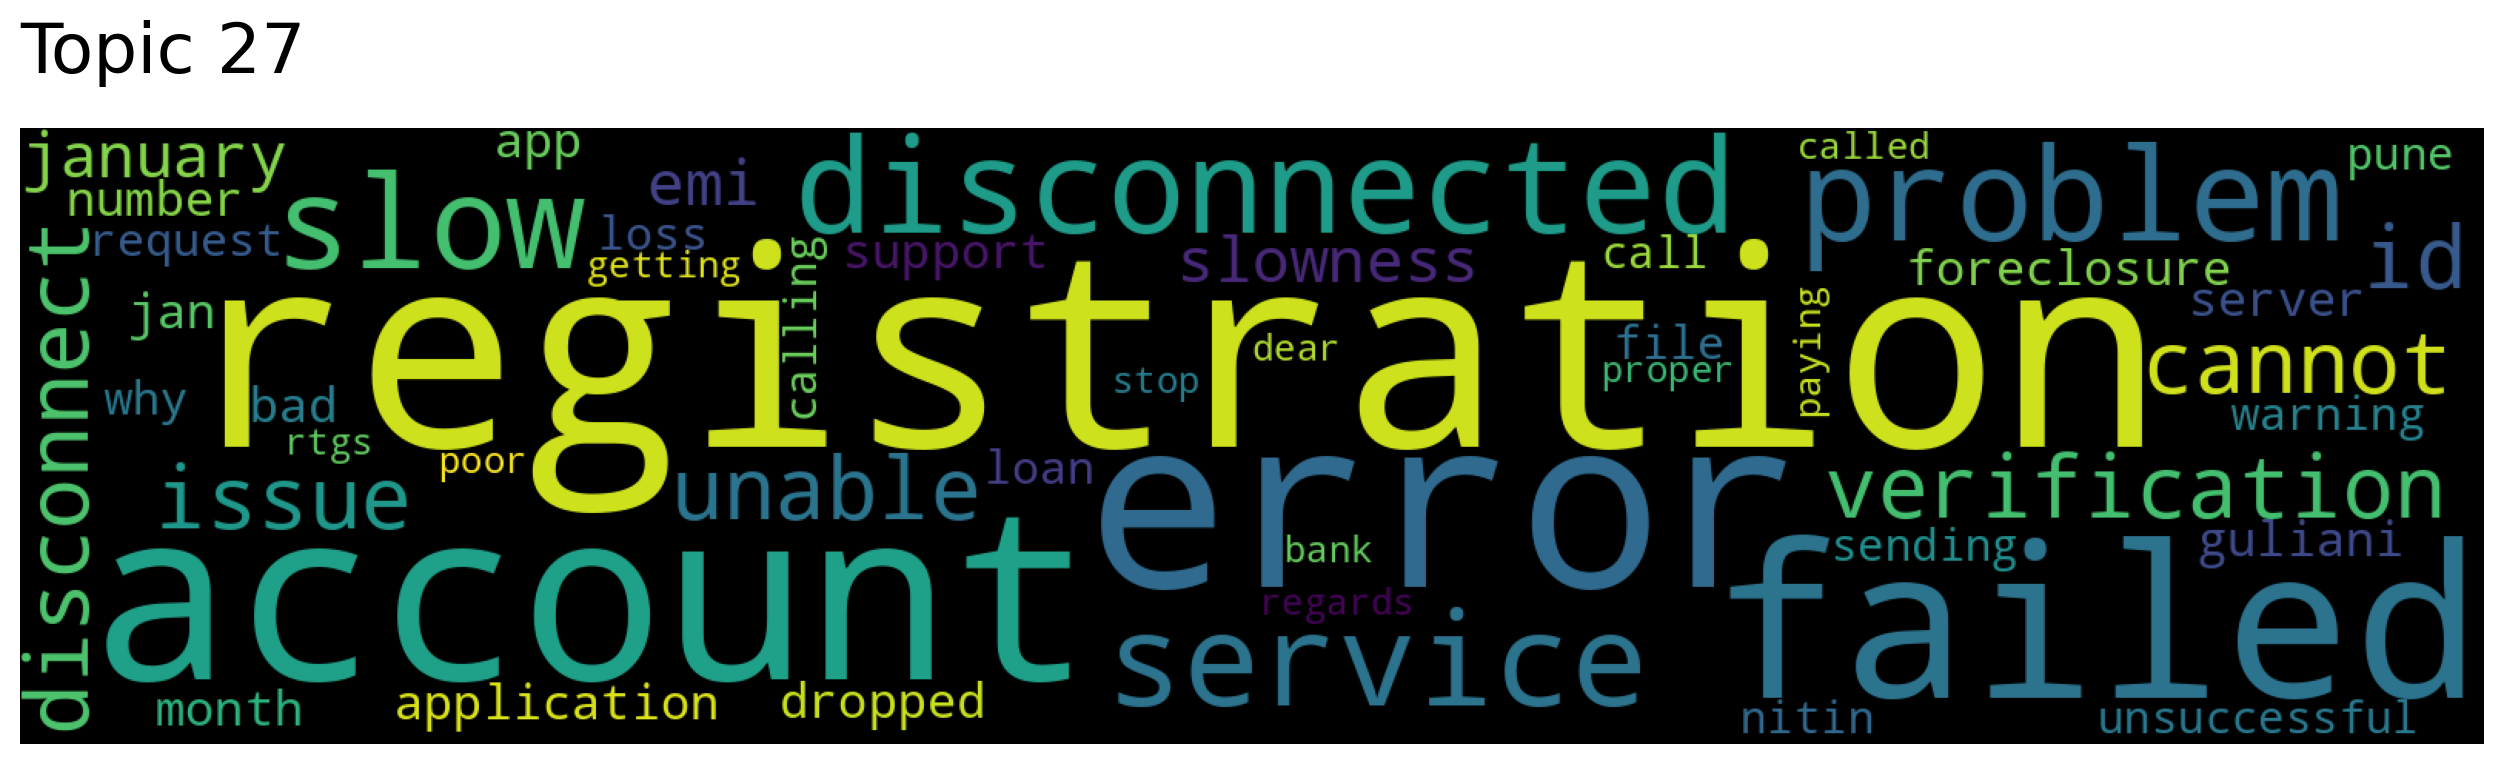

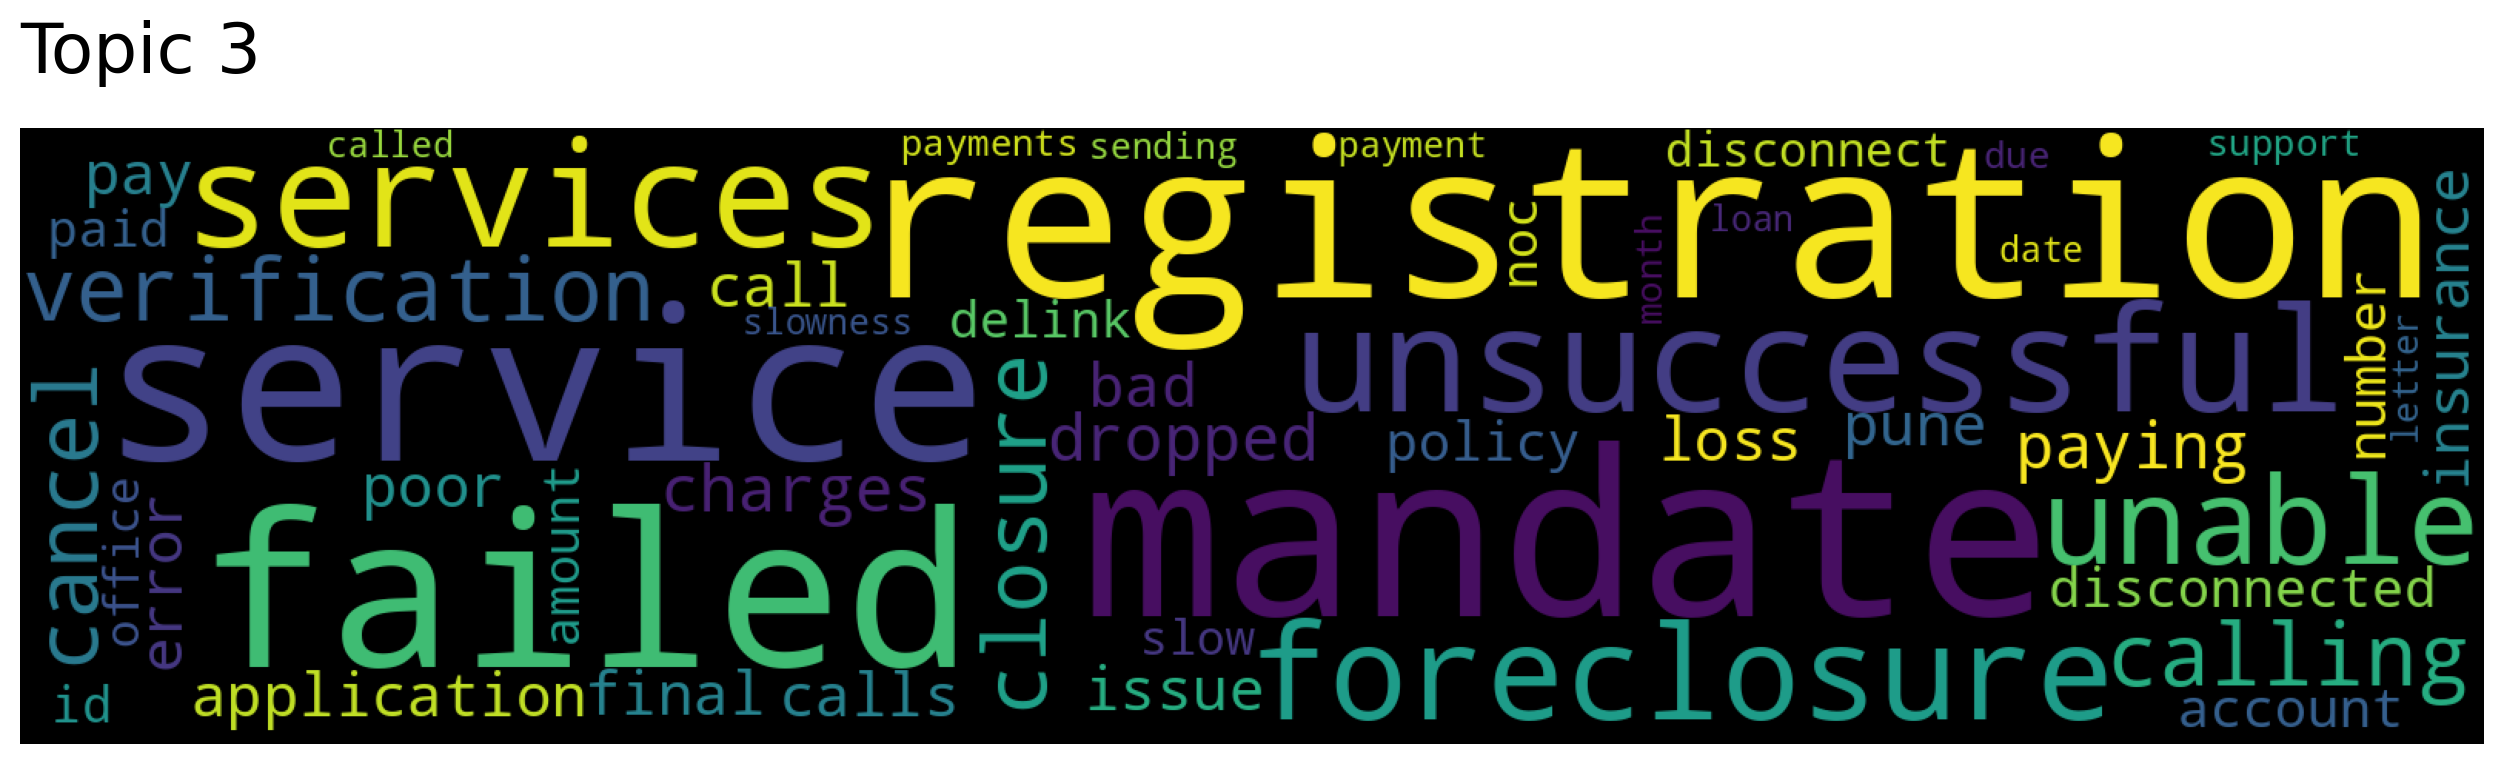

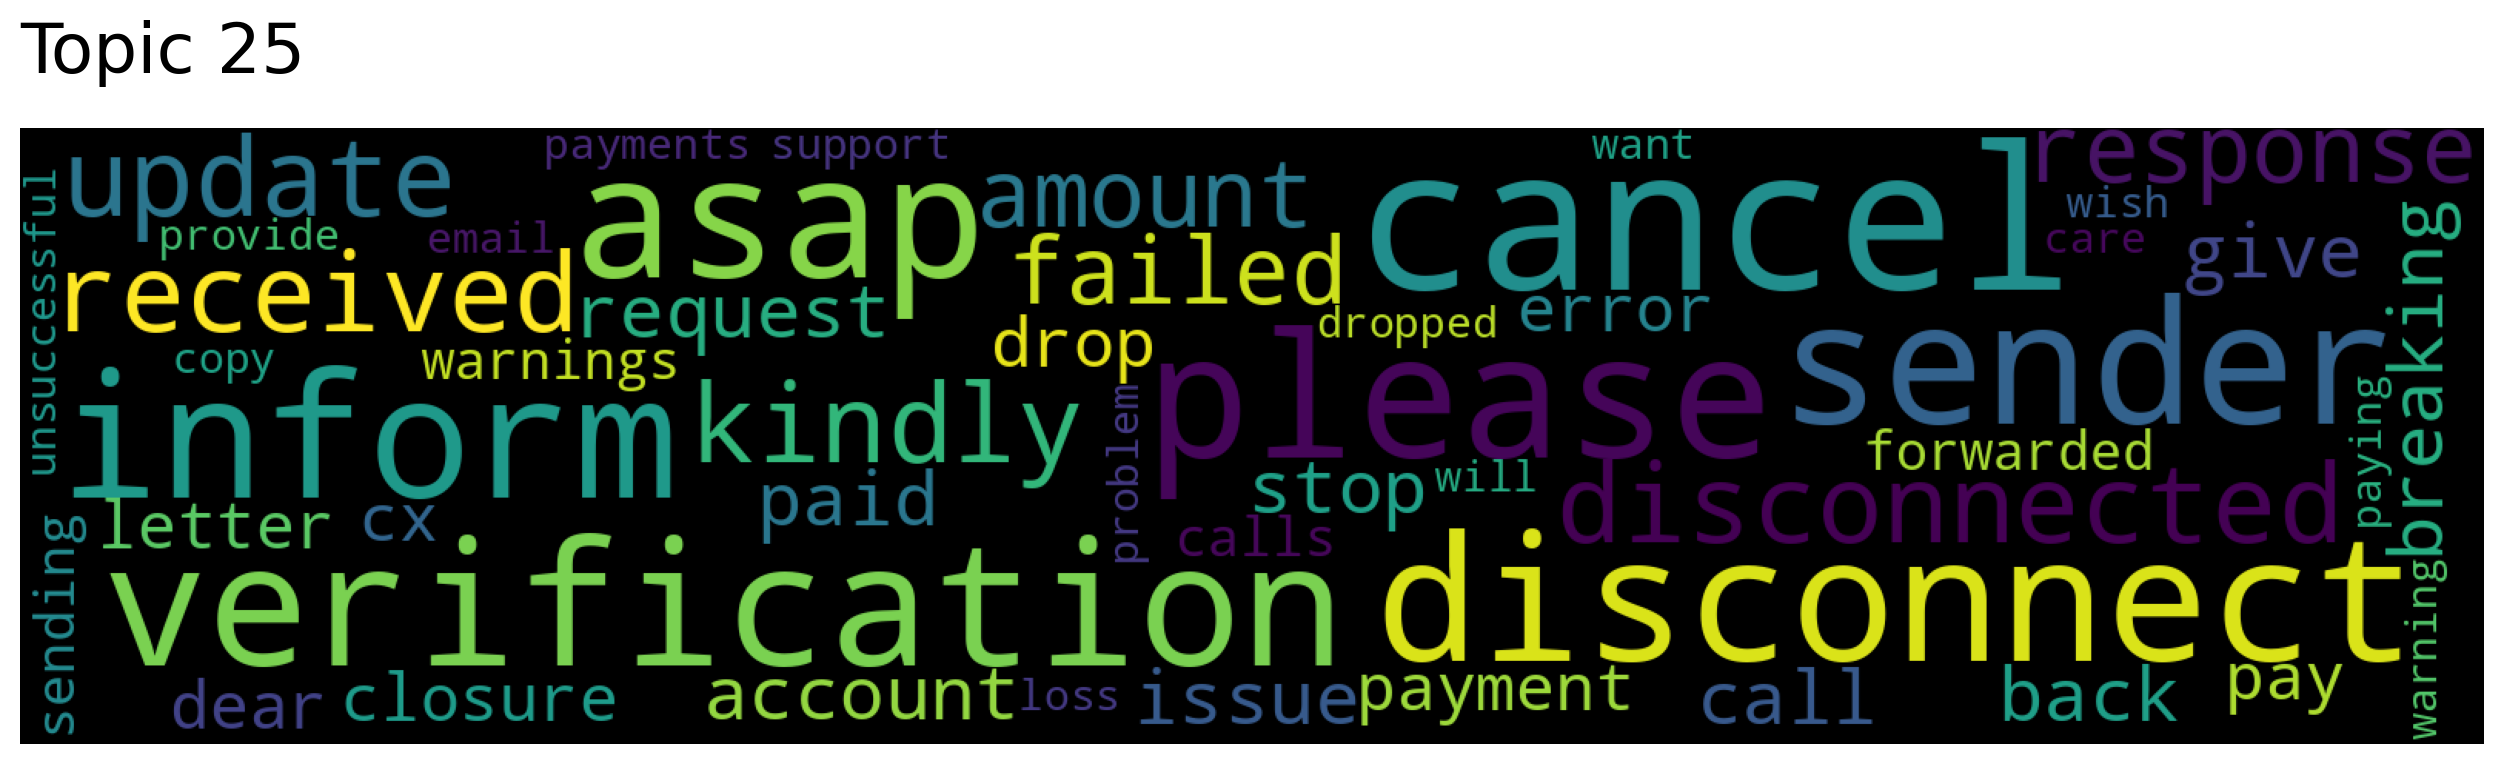

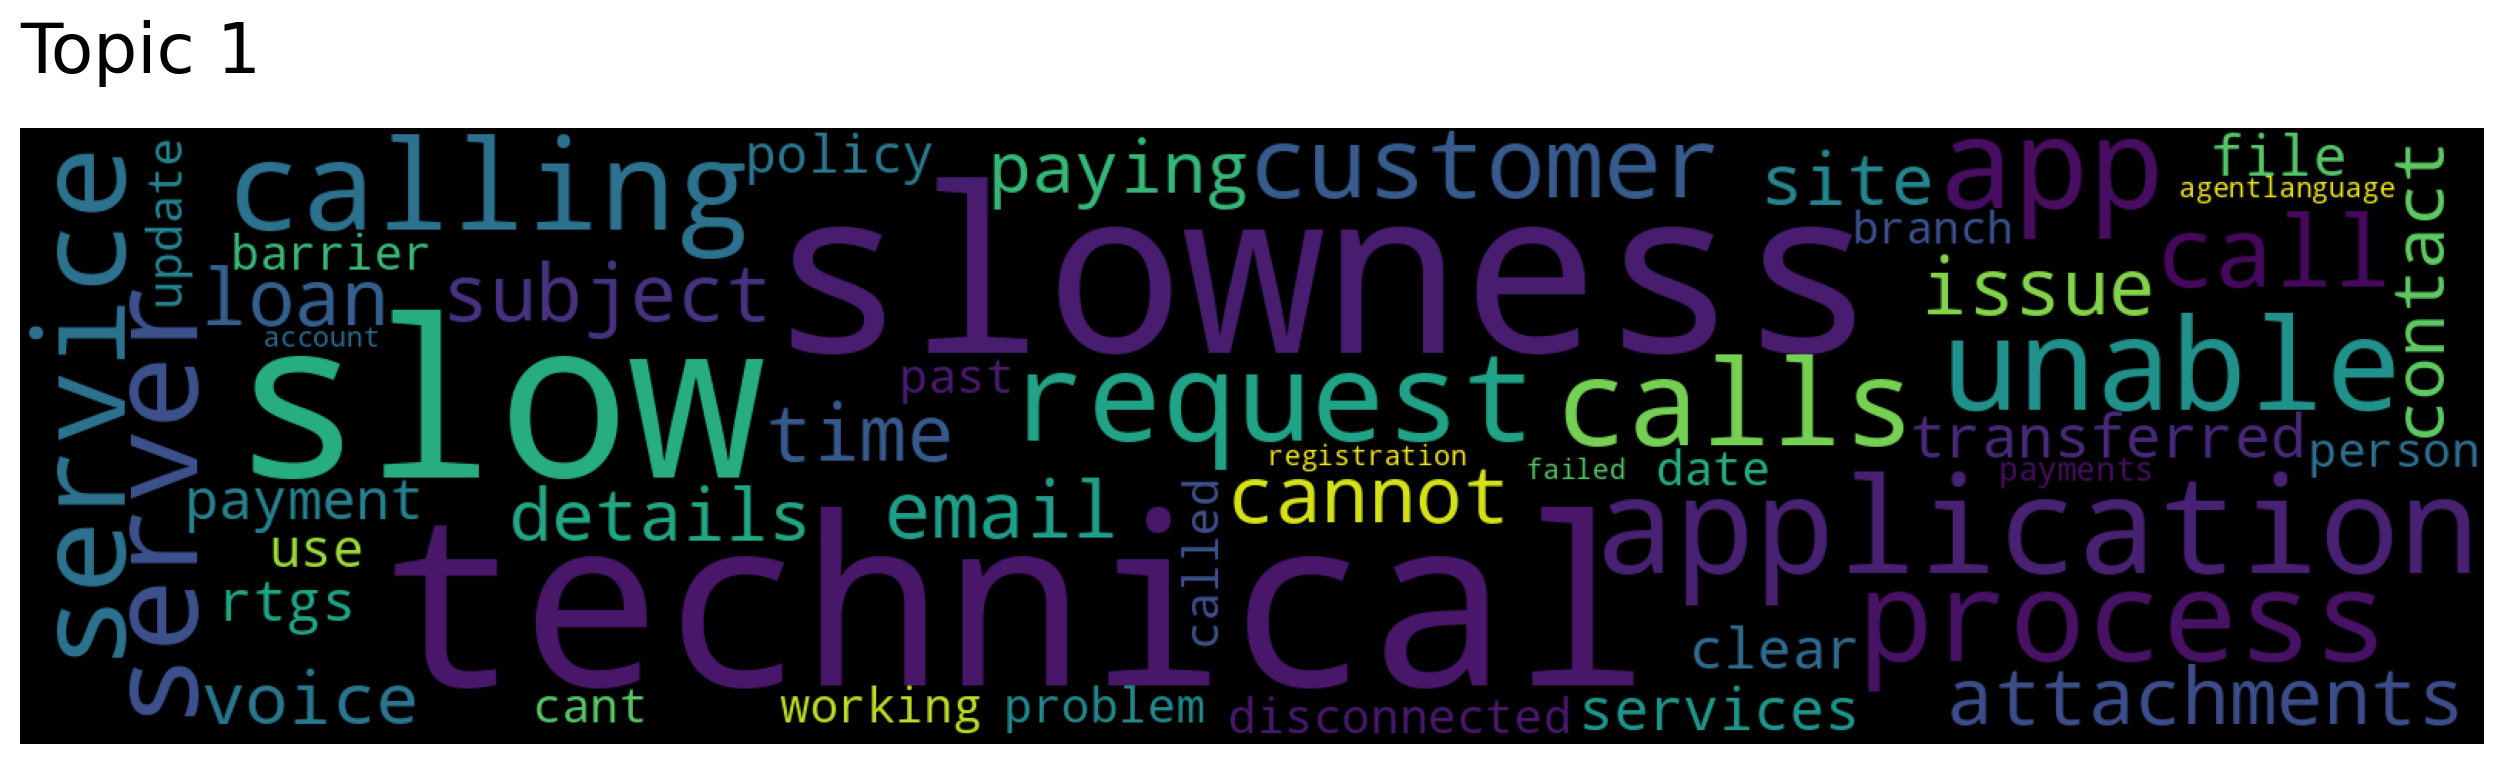

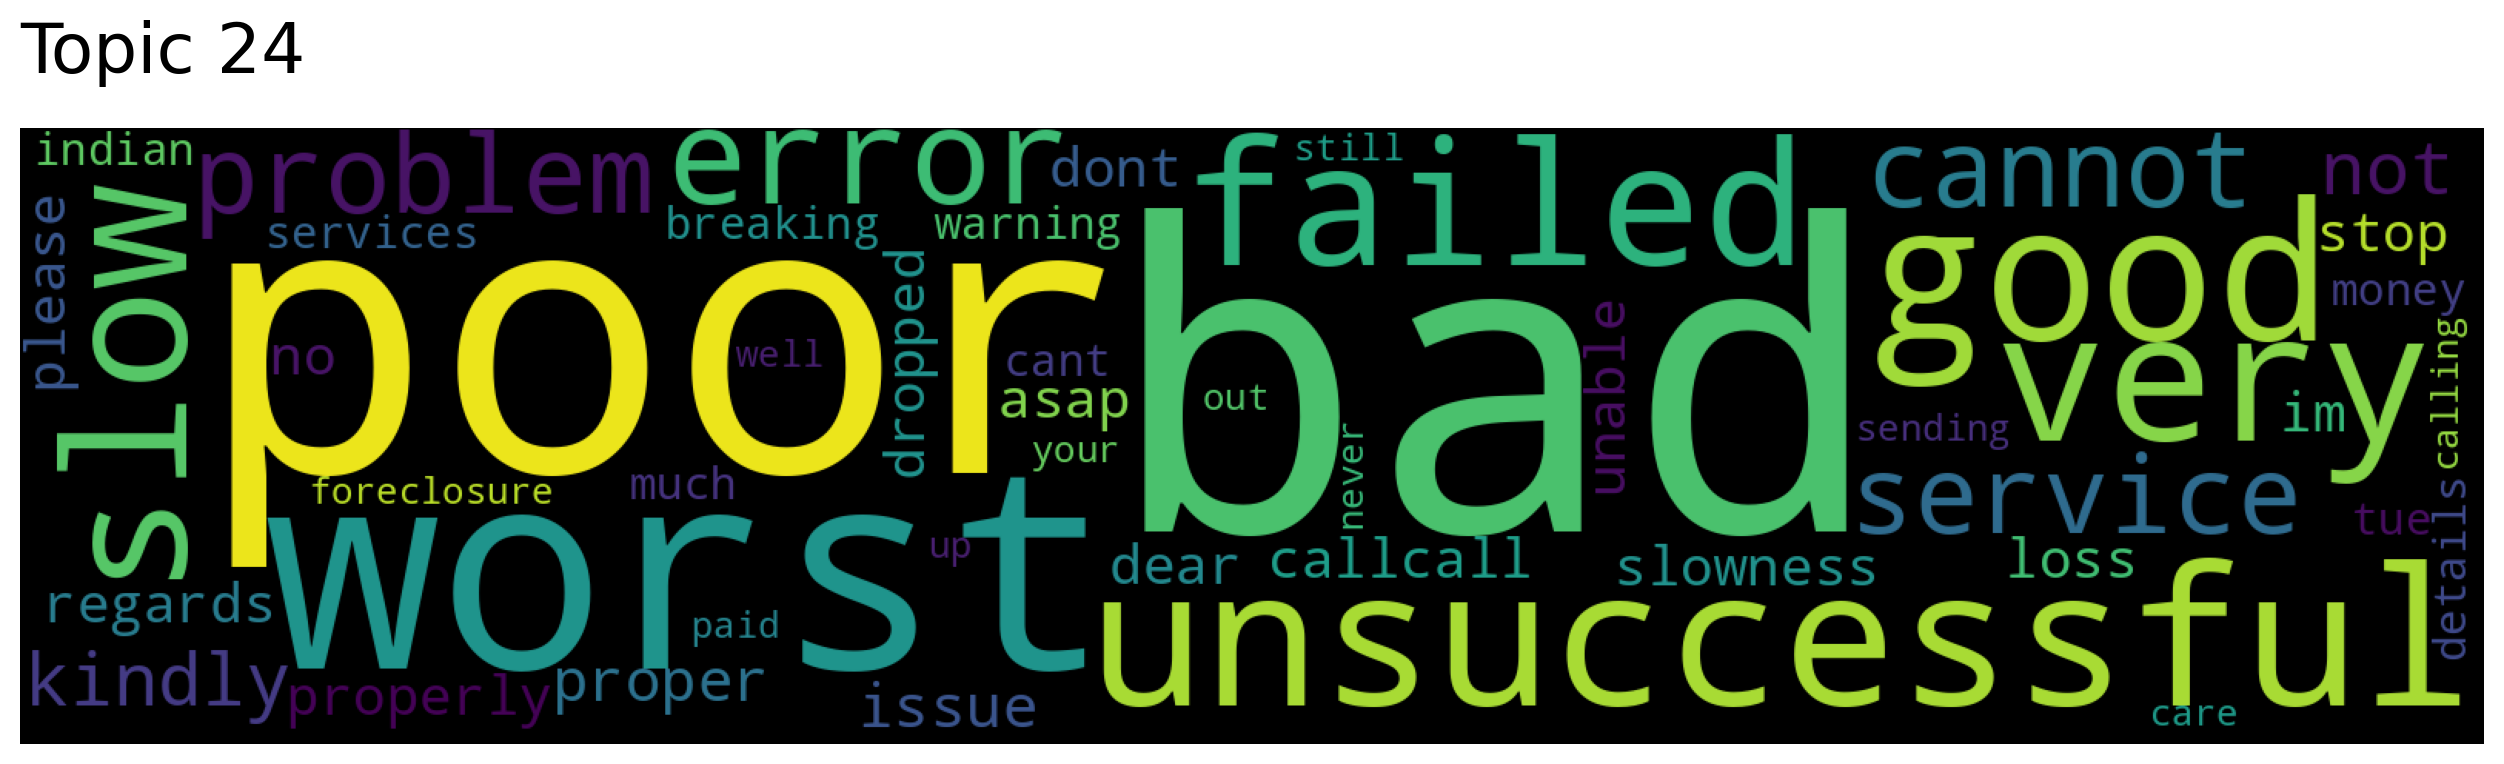

In [32]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["registration"], num_topics=5)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [37]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=17, num_docs=15)

documents: The documents in a list, the most similar are first.

doc_scores: Semantic similarity of document to topic. The cosine similarity of the document and topic vector.

doc_ids: Unique ids of documents. If ids were not given, the index of document in the original corpus

In [36]:
words, word_scores = model.similar_words(keywords=["mandate"], keywords_neg=[], num_words=20)
for word, score in zip(words, word_scores):
    print(f"{word} {score}")

policy 0.4767221469460566
insurance 0.44791785303414244
mr 0.388797173771477
application 0.3843405951958843
pay 0.38068866500668963
account 0.3796095470304633
given 0.3763724285378589
agreement 0.37351970345060675
office 0.37265068170611176
paying 0.3687754916513371
amount 0.3649800765804472
due 0.3530095292044108
calling 0.35295654574865815
proper 0.34932800064314895
payment 0.3485499904638334
support 0.3476702270388242
guliani 0.3470175708298481
number 0.3465050419293345
intended 0.336979159882004
agent 0.3364256144320255


In [33]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["successful"], num_topics=5)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

ValueError: ignored